# Задание

Построить наилучший классификатор (среди KKN, SVM, Decision Tree, Random Forest), который предсказывает этничность по тексту (`./data/etno_home_work.csv`).
* Так как в датасете есть малопредставленные этничности, нужно удалить те, что встречались менее 20 раз.
* Дисбаланс классов (этничностей) решать запрещается.
* Определить какие 30 слов дают наибольший вклад в определение 5 наиболее представленных этничностей.
* Датасет тяжёлый, поэтому хороших метрик от классического ML можно не ждать.

# Настройки/Импорты

In [ ]:
# !pip install pymorphy3
# !pip install pandarallel

In [148]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом

import re # для работы с текстом
import pymorphy3 # для работы с текстом

import psutil # для просмотра числа потоков на cpu
from tqdm import tqdm # для отслеживания прогресса
from pandarallel import pandarallel # для параллельного запуска кода на cpu

from nltk.tokenize import word_tokenize # для токенизации строки
from nltk.corpus import stopwords # стоп-слова

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # векторизаторы текста
from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # метрики
import matplotlib.pyplot as plt # для построения графиков
# from sklearn.inspection import permutation_importance # для подсчёта feature importance
from sklearn.preprocessing import scale # для стандартизации данных

from sklearn.model_selection import ShuffleSplit # для кросс-валидации
# ShuffleSplit - Кросс-валидатор случайной перестановки
# Дает индексы для разбиения данных на обучающий и тестовый наборы.
# Примечание: в отличие от других стратегий кросс-валидации, случайное разбиение не гарантирует,
# что все складки будут разными, хотя для больших наборов данных это вполне вероятно.
from sklearn.model_selection import GridSearchCV # для перебора параметров

from sklearn.neighbors import KNeighborsClassifier # KNN классификатор
from sklearn.svm import SVC # SVM классификатор
from sklearn.ensemble import RandomForestClassifier # Random Forest классификатор
from sklearn.tree import DecisionTreeClassifier # Decision Tree классификатор

import pickle # для сохранения и загрузки объектов

import warnings # для обработки предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning) # игнорируем FutureWarning

In [140]:
DATA_DIR = "./data/" # путь до папки с данными
MODELS_DIR = "./models/" # путь до папки с моделями
CLEANING_VARS = ["none", "trash", "stop_words", "punctuation", "digits", "all"] # варианты очистки текста
ADD_STOP_WORDS = ["тот"] # дополнительные стоп-слова
RANDOM_STATE = 42 # число для задания случайности
TEST_SIZE = 0.2 # размер тестовой выборки
MAX_FEATURES = 15000 # максимальное число фичей после векторизации

NUM_FEATURES = 30 # число фичей (слов) для рассмотрения на внесение самого большого вклада в определение этноса
NUM_ETHNOS = 5 # число самых представленных этносов для рассмотрения на внесение самого большого вклада в определение этноса

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_DIR = "/content/drive/MyDrive/tmp/data/" # путь до папки с данными
# MODELS_DIR = "/content/drive/MyDrive/tmp/models/" # путь до папки с моделями

In [5]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False)) # число доступных топоков

Количество доступных потоков:  1


# Предобработка датасета

In [ ]:
dataset = pd.read_csv(DATA_DIR + "etno_home_work.csv",  sep=';', encoding='utf8', index_col=False) # считывание данных

In [ ]:
dataset # пример содержимого

,source_text,ethno
0,"[[id174199907|Мустафа], мы, украинцы и белорус...",казах
1,"Короче, я сейчас не оправдываюсь, просто хочу ...",казах
2,"[[id211685480|Заур], это связано с твоими слов...",казах
3,RT @VRSoloviev: <a href=\http://youtube.com/wa...,казах
4,Большинство монголов по крови говорят на русск...,казах
...,...,...
5571,"Руслан, если читать про аварцев то и Дудаев и ...",карачаевец
5572,"Абдулатип, у меня есть братья чеченцы , друзья...",карачаевец
5573,Да как вас узкоглазых различишь то? И на кой э...,кавказец
5574,"Интересно, а если Путин или какой-нибудь друго...",кавказец


In [ ]:
dataset["ethno"].value_counts() # проверка целевых значений

ethno
казах              367
азербайджанец      355
аварец             224
калмык             162
кавказец           154
                  ... 
индиец               1
уйгурский            1
башкирский_прил      1
балкарский_прил      1
финский_прил         1
Name: count, Length: 178, dtype: int64

**В датасете получилось 178 уникальных этносов, однако по заданию требуется убрать те, записи о которых встречаются менее 20 раз.**

In [ ]:
dataset = dataset[(dataset["ethno"].value_counts()[dataset["ethno"]] >= 20).values] # оставляем записи только про те этносы, которые встречались не менее 20 раз
# dataset["ethno"].value_counts() — возвращает Series object (словарь) с количеством встреченных значений
# dataset["ethno"].value_counts()[dataset["ethno"]] — как бы рассматриваем  записи, где вместо этноса в строке идёт количество записей об этом этносе в датасете
# (dataset["ethno"].value_counts()[dataset["ethno"]] >= 20).values — вернёт массив из True/False размера массива, где True ставится тем записям, у которых записей про этнос >= 20 ====> если True, то запись оставляем, иначе — удаляем

In [ ]:
dataset.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True и перезаписываем существующий датасет)

In [ ]:
dataset["ethno"].value_counts() # проверка целевых значений

ethno
казах            367
азербайджанец    355
аварец           224
калмык           162
кавказец         154
                ... 
чудь              21
мариец            21
абориген          20
гагауз            20
аланы             20
Name: count, Length: 70, dtype: int64

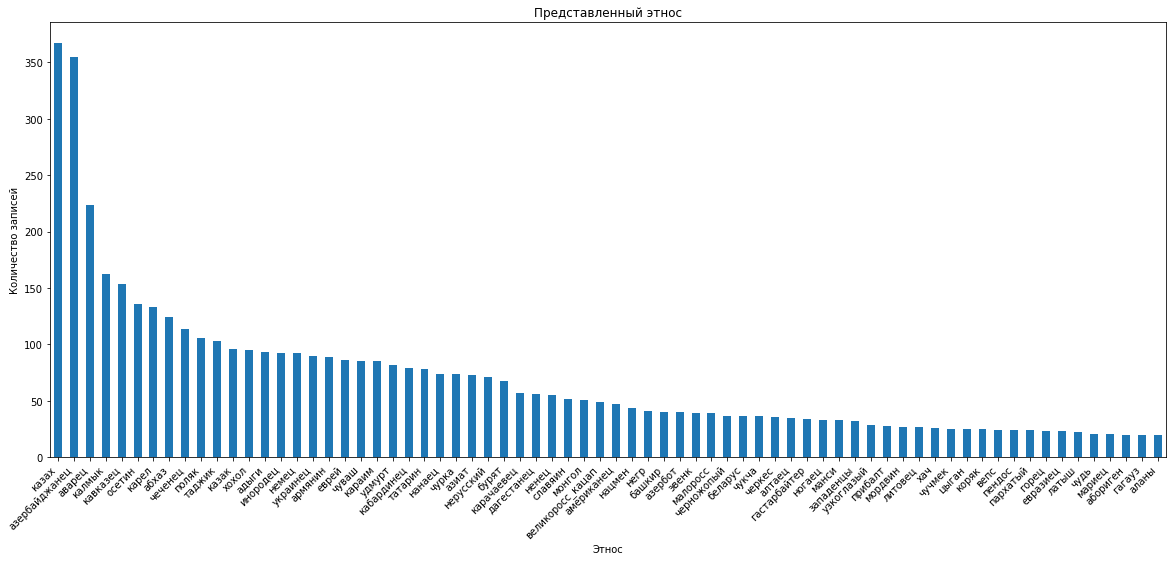

In [ ]:
plt.figure(figsize=(20,8)) # задание размера графика
dataset["ethno"].value_counts().plot.bar() # построение столбчатой диаграммы по данным
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title('Представленный этнос') # название графика
plt.xlabel('Этнос') # подпись по оси x
plt.ylabel('Количество записей') # подпись по оси y
plt.show() # вывод графика

**После удаления осталось 70 этносов.**

In [ ]:
dataset["source_text"] = dataset["source_text"].astype('string') # приводим колонку к типу строки

C:\Users\User\Documents\TEMP\ipykernel_15672\365316129.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["source_text"] = dataset["source_text"].astype('string') # приводим колонку к типу строки


In [ ]:
dataset.isnull().sum() # проверка наличия пропущенных значений

source_text    0
ethno          0
dtype: int64

**Пропущенных значений в датасете не оказалось.**

## Очистка текста

In [ ]:
pandarallel.initialize() # запуск в параллельном режиме

def clear_data(df: pd.DataFrame, var) -> pd.DataFrame:
    # лишние пробелы можно не удалять, так как word_tokenize их сам уберёт

    # импортируем, так как потоки их перестанут видеть
    import re
    from nltk.tokenize import word_tokenize
    import pymorphy3

    morph = pymorphy3.MorphAnalyzer() # объект для лемматизации слов

    stop_words = stopwords.words('russian') # список стоп-слов для русского языка
    for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
        stop_words.append(add_stop) # добавляем стоп-слово

    df['source_text'] = df['source_text'].parallel_apply(lambda text: text.lower()) # приводим к нижнему регистру

    if var in ["trash", "all"]:
        df['source_text'] = df['source_text'].parallel_apply(lambda text: re.sub('\[\[\w*d*\|', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])
        df['source_text'] = df['source_text'].parallel_apply(lambda text: re.sub(']', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])

        df['source_text'] = df['source_text'].parallel_apply(lambda text: re.sub('@\S*', '', text)) # убираем тегирование

        df['source_text'] = df['source_text'].parallel_apply(lambda text: re.sub('<.*?>', '', text)) # убираем html элементы


    if var in ["punctuation", "all"]:
        df['source_text'] = df['source_text'].parallel_apply(lambda text: re.sub(r"[,.…?:;/\\!@#$#—+=ツ►๑۞۩•«»“”˜°*`\")(%]", '', text)) # удаляем различную пунктуацию
        df['source_text'] = df['source_text'].parallel_apply(lambda text: re.sub("-", ' ', text)) # заменяем тире на пробел


    if var in ["digits", "all"]:
        df['source_text'] = df['source_text'].parallel_apply(lambda text: re.sub('\d', '', text)) # удаляем цифры


    df['source_text'] = df['source_text'].parallel_apply(lambda text: word_tokenize(text)) # разбиваем текст на токены
    df['source_text'] = df['source_text'].parallel_apply(lambda text: [morph.parse(word)[0].normal_form for word in text]) # приводим слова к нормальной форме (если она у них есть, иначе они остаются без изменения)

    if var in ["stop_words", "all"]:
        df['source_text'] = df['source_text'].parallel_apply(lambda text: [word for word in text if word not in stop_words]) # удаляем стоп-слова

    df['source_text'] = df['source_text'].parallel_apply(lambda text: ' '.join(text)) # собираем токены обратно в строку
    df["source_text"] = df["source_text"].astype('string') # приводим колонку к типу строки (чтобы у записей не было начальных и конечных кавычек)

    return df # возвращаем обработанный датасет

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    clear_data(dataset.copy(), var).to_csv(DATA_DIR + f"data_{var}.csv", sep=";", index=False) # сохраняем полученный датасет (index=False — без сохранения индексов)

100%|██████████| 6/6 [07:11<00:00, 71.85s/it]


# Feature importance, основываясь на распределении данных в датасете

**На примере датасета с обработкой "all".**

In [156]:
dataset = pd.read_csv(DATA_DIR + "data_all.csv",  sep=';', encoding='utf8', index_col=False) # считывание данных

In [157]:
dataset["ethno"].value_counts()[:5] # самые представленные этонсы

ethno
казах            367
азербайджанец    355
аварец           224
калмык           162
кавказец         154
Name: count, dtype: int64

In [158]:
top_presented_ethnos = dataset["ethno"].value_counts()[:NUM_ETHNOS].keys() # топ 5 представленных этносов в датасете
top_presented_ethnos

Index(['казах', 'азербайджанец', 'аварец', 'калмык', 'кавказец'], dtype='object', name='ethno')

In [159]:
vectorizer = CountVectorizer(ngram_range=(1,1), max_features=MAX_FEATURES) # векторизатор (с ограничением на число фичей MAX_FEATURES)
data_X = vectorizer.fit_transform(dataset['source_text']).toarray() # конвертируем документы (текста) в вектора

In [160]:
features_names = vectorizer.get_feature_names_out() # названия (слова) фич

In [165]:
for ethno in top_presented_ethnos: # идём по рассматриваемым этносам
    rows_with_ethno = dataset.index[dataset['ethno'] == ethno].tolist() # строки, соответствующие рассматриваемому этносу
    mean_for_ethno = data_X[rows_with_ethno].mean(axis=0) # считаем среднее по столбцам (фичам), рассматривая только строки, соответствующие рассматриваемому этносу

    rows_without_ethno = dataset.index[dataset['ethno'] != ethno].tolist() # строки, не соответствующие рассматриваемому этносу
    mean_for_other = data_X[rows_without_ethno].mean(axis=0) # считаем среднее по столбцам (фичам), рассматривая только строки, что не соответствуют рассматриваемому этносу

    mean_diff = mean_for_ethno - mean_for_other # считаем разницу средних значений в распределениях рассматриваемого этноса и всех остальных

    indices = np.argsort(mean_diff)[::-1] # индексы элементов в порядке уменьшения разницы (меньшей выразительности)

    print(f"Для этноса '{ethno}' специфичны слова:")
    for i in range(NUM_FEATURES): # идём по числу фич, что нужно получить для одного этноса
        print(f"{i+1}) {features_names[indices[i]]} ({indices[i]})")

Для этноса 'казах' специфичны слова:
1) народ (5046)
2) год (1965)
3) армянин (525)
4) слово (10507)
5) путин (9064)
6) кстати (4110)
7) племя (6509)
8) большой (945)
9) европа (2652)
10) население (5070)
11) государство (2040)
12) жить (2782)
13) посмотреть (7743)
14) который (3995)
15) плохой (6552)
16) дагестан (2165)
17) интерес (3362)
18) считать (11295)
19) кумык (4136)
20) аварец (240)
21) ингуш (3324)
22) rt (162)
23) бежать (751)
24) сей (10288)
25) погибнуть (6707)
26) gt (55)
27) националист (5148)
28) крым (4095)
29) пример (8513)
30) название (4950)
Для этноса 'азербайджанец' специфичны слова:
1) русский (9741)
2) весь (1233)
3) ненавидеть (5277)
4) часть (13581)
5) сталин (10897)
6) уничтожить (12272)
7) тысяча (12006)
8) крым (4095)
9) всё (1626)
10) еврей (2644)
11) россия (9522)
12) тыс (12005)
13) крымский (4098)
14) вообще (1495)
15) литовец (4297)
16) имя (3317)
17) татарин (11573)
18) этнос (14685)
19) язык (14840)
20) российский (9520)
21) стоить (10964)
22) дагес

# Обучение моделей

In [3]:
models = {} # словарь под полученные классификаторы вида
# {"classifier 1":
#   {
#     "var 1": классификатор,
#     "var 2": классификатор,
#     ...
#   }, ...
# }

In [4]:
data = {} # словарь под все варианты обработки вида
# {"var 1":
#   {
#     "X_train": [...],
#     "X_test": [...],
#     "y_train": [...],
#     "y_test": [...],
#     "vectorizer": векторизатор
#   }, ...
# }

for var in CLEANING_VARS: # идём по вариантам обработки
    dataset = pd.read_csv(DATA_DIR + f"data_{var}.csv",  sep=';', encoding='utf8', index_col=False) # считывание данных

    vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=MAX_FEATURES) # векторизатор (с ограничением на число фичей MAX_FEATURES)
    data_X = vectorizer.fit_transform(dataset['source_text']).toarray() # конвертируем документы (текста) в вектора
    print(f"Размерность при варианте обработки '{var}': сэмплов — {data_X.shape[0]}, фичей — {data_X.shape[1]}")

    factorizer = pd.factorize(dataset['ethno']) # перевод строковых таргетов (type: object) в числовой формат (type: int)
    data_y = factorizer[0] # таргеты (уже в числовом формате)

    data[var] = {} # заготовка под сплит
    data[var]["X_train"], data[var]["X_test"], data[var]["y_train"], data[var]["y_test"] = train_test_split(data_X, data_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_y)
    # разбиваем датасет (dataset["source_text"] — данные, dataset["ethno"] — таргеты) на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify=data_y) в обоих выборках
    data[var]["vectorizer"] = vectorizer # векторизатор

Размерность при варианте обработки 'none': сэмплов — 4858, фичей — 15000
Размерность при варианте обработки 'trash': сэмплов — 4858, фичей — 15000
Размерность при варианте обработки 'stop_words': сэмплов — 4858, фичей — 15000
Размерность при варианте обработки 'punctuation': сэмплов — 4858, фичей — 15000
Размерность при варианте обработки 'digits': сэмплов — 4858, фичей — 15000
Размерность при варианте обработки 'all': сэмплов — 4858, фичей — 15000


In [5]:
custom_cv = ShuffleSplit(n_splits=2, test_size=TEST_SIZE, random_state=RANDOM_STATE) # кастомный кросс-валидатор
# n_splits — число разбиений для кросс-валидации
# test_size — размер тестовой выборки

In [6]:
def model_train(model, params, X_train, y_train, cv, scoring="f1_macro") -> GridSearchCV: # функция для обучения моделей
    """
    Универсальная функция для обучения классификаторов.\n
    Parameters:
        * model: классификатор
        * params: параметры для перебора в GreedSearch
        * X_train: данные для обучения
        * y_train: таргеты для обучения
        * cv: метод для кросс-валидации
        * scoring: метрика для выбора лучшей модели\n
    Returns:
        * GridSearchCV: объект, содержащий
    """
    greed_search = GridSearchCV(model, params, cv=cv , scoring=scoring, n_jobs=1, verbose=10) # передаём параметры в GridSearchCV

    greed_search.fit(X_train, y_train) # обучаем модель

    return greed_search # возвращаем обученный классификатор

In [7]:
def models_best(models_gs):
    best_classifier = None
    best_score = 0 # лучший score
    best_var = None # лучший вариант предобработки

    for var in CLEANING_VARS: # идём по вариантам обработки
        if models_gs[var].best_score_ > best_score:
            best_score = models_gs[var].best_score_
            best_classifier = models_gs[var].best_estimator_
            best_var = var
    print(f"Лучший score={best_score:.4f} при обработке '{best_var}'")
    return best_classifier, best_var

In [8]:
def model_evaluate(model, X_test, y_test):
    preds = model.predict(X_test)

    print(classification_report(y_test, preds, target_names=factorizer[1], zero_division=0))

    fig, ax = plt.subplots(figsize=(20,20)) # создание "фигуры"
    ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels=factorizer[1]).plot(ax=ax) # строим confusion matrix
    fig.autofmt_xdate(rotation=45, ha='right')

In [9]:
def model_save(model, file_name):
    with open(f"{MODELS_DIR}{file_name}.pkl", 'wb') as f: # открытие файла для записи ('w')
        pickle.dump(model, f) # сохраняем в него данные о фильмах

In [10]:
def model_load(file_name):
    with open(f"{MODELS_DIR}{file_name}.pkl", 'rb') as f: # открытие файла для записи ('w')
        return pickle.load(f) # сохраняем в него данные о фильмах

In [ ]:
# def plot_feature_importances(model, X, y, feature_names,  scoring="f1_macro", title="Feature importances using permutation"):
#     result = permutation_importance(model, X, y, n_repeats=5, scoring=scoring, random_state=RANDOM_STATE, n_jobs=-1)
#     # df = pd.DataFrame({'feature_name': feature_names, 'feature_importance': result.importances_mean})
#     plt.figure(figsize=(10, 10))
#     # sns.barplot(data=df, x='feature_importance', y='feature_name')
#     fig, ax = plt.subplots()
#     result.plot.bar(yerr=result.importances_std, ax=ax)

#     plt.title(title) # название графика
#     plt.ylabel("Mean accuracy decrease") # подпись по оси y
#     plt.show()

## 1) K-Nearest Neighbors (KNN)

In [ ]:
params_KNN = [{
    'n_neighbors': list(range(1, 10)), # кол-во соседей
    'weights': ['uniform', 'distance'], # вдияние расстояния до соседа на его вклад ("uniform" — нет влияния, "distance" — чем ближе, тем больше вклад)
    'metric': ["minkowski"], # метрика для подсчёта расстояния между объектами
    'p': [2], # степень в метрике Минковского расстояния (2 ~ расстояние евклидово)
    'algorithm': ['auto'], # алгоритм для подсчёта ближайших соседей
    }]

In [ ]:
models["KNN"] = {} # создаём заготовку под классификатор

for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    gs_model = model_train(KNeighborsClassifier(), params_KNN, data[var]["X_train"], data[var]["y_train"], custom_cv) # вызываем скрипт обучения
    models["KNN"][var] = gs_model # сохраняем то, что вернул GreedSearch

100%|██████████| 6/6 [04:56<00:00, 49.41s/it]


Находим лучшую комбинацию параметров модели и обработки датасета.

In [ ]:
best_KNN, best_KNN_var = models_best(models["KNN"]) # находим лучшую комбинацию параметров модели и обработки датасета

Лучший score=0.0299 при обработке 'trash'


In [17]:
best_KNN.get_params() # лучшие параметры

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'distance'}

In [ ]:
model_save(best_KNN, f"KNN_{best_KNN_var}") # сохраняем лучшую модель (с указанием варианта очистки текста)

In [11]:
# best_KNN = model_load("KNN_trash")
# best_KNN_var = "trash"

                  precision    recall  f1-score   support

           казах       0.11      0.09      0.10        74
           азиат       0.00      0.00      0.00        15
      кабардинец       0.08      0.06      0.07        16
           казак       0.05      0.05      0.05        19
          калмык       0.05      0.06      0.06        32
           поляк       0.06      0.10      0.08        21
          аварец       0.08      0.11      0.10        45
          осетин       0.00      0.00      0.00        27
   азербайджанец       0.07      0.08      0.07        71
         азербот       0.00      0.00      0.00         8
           абхаз       0.00      0.00      0.00        25
           эвенк       0.00      0.00      0.00         8
         чеченец       0.00      0.00      0.00        23
           горец       0.00      0.00      0.00         5
          черкес       0.00      0.00      0.00         7
      карачаевец       0.07      0.09      0.08        11
           ад

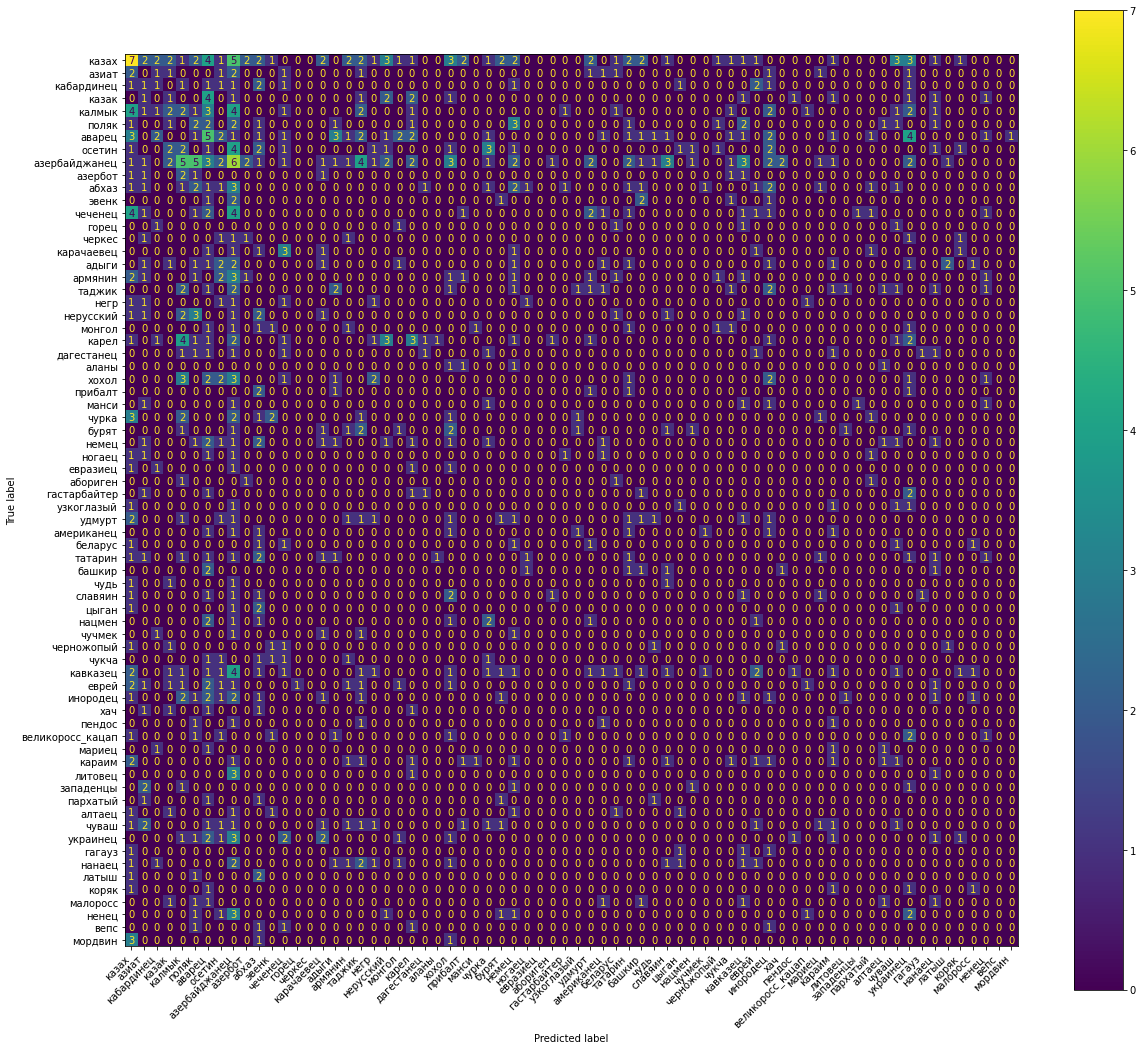

In [16]:
model_evaluate(best_KNN, data[best_KNN_var]["X_test"], data[best_KNN_var]["y_test"]) # оцениваем предсказание лучшей модели на соответствующем типе обработки

**KNN модель очень плохо справилась с задачей классификации.**

## 2) Support Vector Machine (SVM)

SVM будет рассмотрен только с вариантом очистки "trash", так как его обучение занимает очень много времени.

In [ ]:
# params_SVM = [{
#     "C":  [0.1, 1.0, 10.0], # параметр регуляризации; сила регуляризации обратно пропорциональна C
#     "kernel": ["rbf", "linear", "poly", "sigmoid"], # тип используемого ядра
#     "gamma": [0.001, 0.0001, "scale"], # коэффициент для ядер (‘rbf’, ‘poly’, ‘sigmoid’)
#     "degree": list(range(2, 5)), # степень функции ядра "poly"
#     "class_weight": [None, "balanced"], # балансировка весов для классов
#     # "random_state": [RANDOM_STATE], # число для задания случайности
#     }]

params_SVM = [{
    "C":  [0.1, 1.0, 10.0], # параметр регуляризации; сила регуляризации обратно пропорциональна C
    "kernel": ["poly"], # тип используемого ядра
    "gamma": [0.001, 0.0001, "scale"], # коэффициент для ядер (‘rbf’, ‘poly’, ‘sigmoid’)
    "degree": [3, 4, 5], # степень функции ядра "poly"
    "class_weight": ["balanced"], # балансировка весов для классов
    "random_state": [RANDOM_STATE], # число для задания случайности
    },{
    "C":  [0.1, 1.0, 10.0], # параметр регуляризации; сила регуляризации обратно пропорциональна C
    "kernel": ["linear"], # тип используемого ядра
    "class_weight": ["balanced"], # балансировка весов для классов
    "random_state": [RANDOM_STATE], # число для задания случайности
    },{
    "C":  [0.1, 1.0, 10.0], # параметр регуляризации; сила регуляризации обратно пропорциональна C
    "kernel": ["rbf"], # тип используемого ядра
    "gamma": [0.001, 0.0001, "scale"], # коэффициент для ядер (‘rbf’, ‘poly’, ‘sigmoid’)
    "class_weight": ["balanced"], # балансировка весов для классов
    "random_state": [RANDOM_STATE], # число для задания случайности
    }]

In [ ]:
models["SVM"] = {} # создаём заготовку под классификатор

for var in tqdm(["trash"]): # идём по вариантам обработки
    gs_model = model_train(SVC(), params_SVM, data[var]["X_train"], data[var]["y_train"], custom_cv) # вызываем скрипт обучения
    models["SVM"][var] = gs_model # сохраняем то, что вернул GreedSearch

Находим лучшую комбинацию параметров модели и обработки датасета.

In [176]:
best_SVM, best_SVM_var = models_best(models["SVM"]) # находим лучшую комбинацию параметров модели и обработки датасета

Лучший score=0.0238 при обработке 'trash'


In [180]:
best_SVM.get_params() # лучшие параметры

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
model_save(best_SVM, f"SVM_{best_SVM_var}") # сохраняем лучшую модель (с указанием варианта очистки текста)

In [179]:
# best_SVM = model_load("SVM_trash")
# best_SVM_var = "trash"

                  precision    recall  f1-score   support

           казах       0.07      0.23      0.11        74
           азиат       0.00      0.00      0.00        15
      кабардинец       0.08      0.06      0.07        16
           казак       0.00      0.00      0.00        19
          калмык       0.02      0.12      0.04        32
           поляк       0.00      0.00      0.00        21
          аварец       0.00      0.00      0.00        45
          осетин       0.03      0.19      0.05        27
   азербайджанец       0.19      0.04      0.07        71
         азербот       0.00      0.00      0.00         8
           абхаз       0.00      0.00      0.00        25
           эвенк       0.00      0.00      0.00         8
         чеченец       0.02      0.04      0.03        23
           горец       0.00      0.00      0.00         5
          черкес       0.00      0.00      0.00         7
      карачаевец       0.00      0.00      0.00        11
           ад

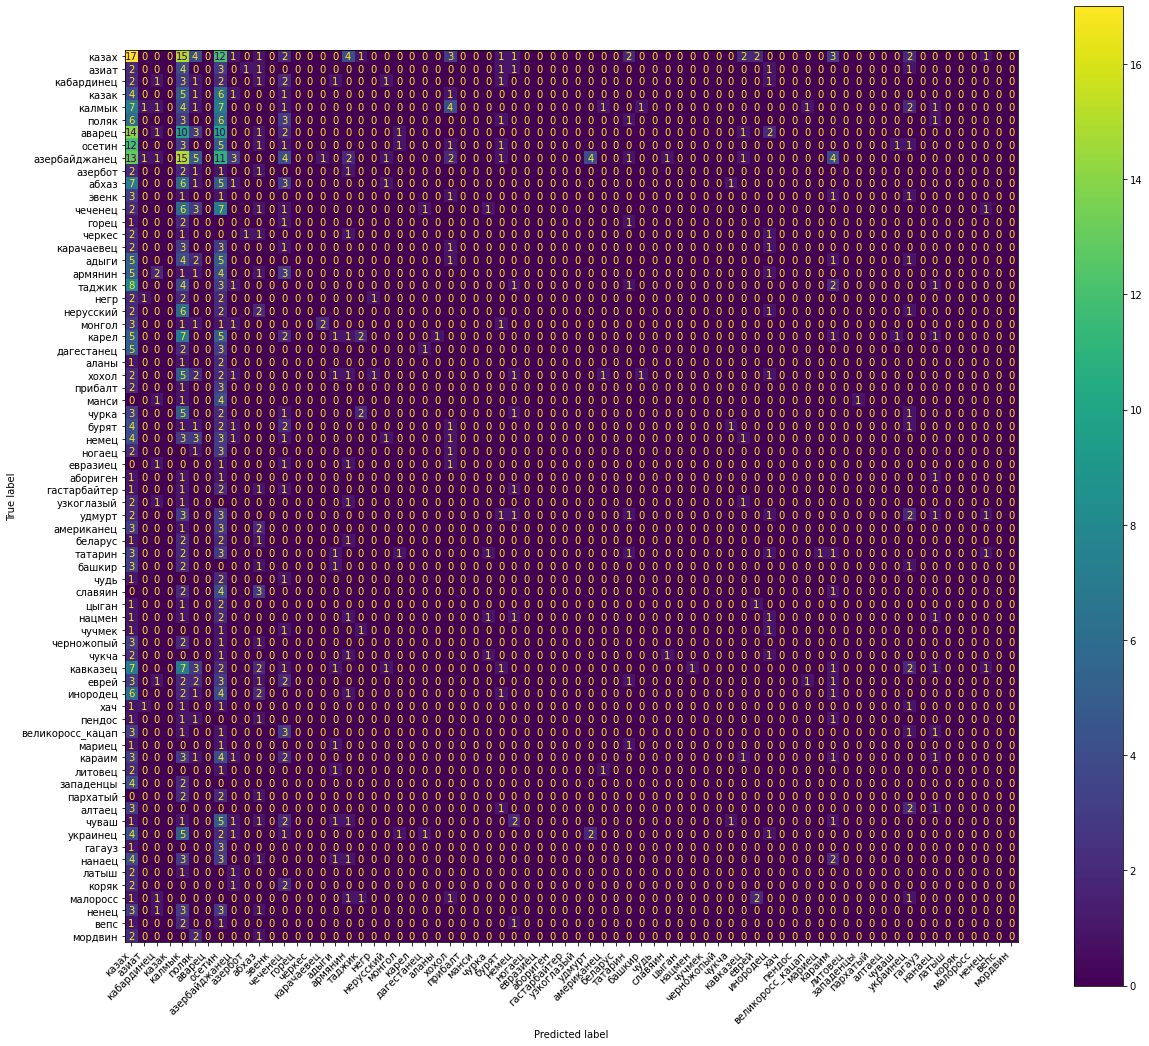

In [181]:
model_evaluate(best_SVM, data[best_SVM_var]["X_test"], data[best_SVM_var]["y_test"]) # оцениваем предсказание лучшей модели на соответствующем типе обработки

## 3) Decision Tree

In [47]:
# params_DT = [{
#     "criterion": ["gini", "entropy", "log_loss"], # критерий для оценивания качества разбиения
#     "max_depth": [5, 10, 20, 50], # максимальная глубина дерева
#     "min_samples_split": [5,10, 50, 100], # минимальное число сэмплов в узле для разбиения
#     "max_features": [None, "sqrt", "log2"], # число рассматриваемых фичей ('столбцов' в датасете) при делении в узле (для best split)
#     "class_weight": [None, "balanced"], # балансировка весов для классов
#     # "random_state": [RANDOM_STATE], # число для задания случайности
#     }]

params_DT = [{
    "criterion": ["gini", "entropy"], # критерий для оценивания качества разбиения
    "max_depth": [10, 15, 20], # максимальная глубина дерева
    "min_samples_split": [10, 50, 100], # минимальное число сэмплов в узле для разбиения
    "max_features": [None, "sqrt", "log2"], # число рассматриваемых фичей ('столбцов' в датасете) при делении в узле (для best split)
    "class_weight": [None, "balanced"], # балансировка весов для классов
    "random_state": [RANDOM_STATE], # число для задания случайности
    }]

In [ ]:
models["DT"] = {} # создаём заготовку под классификатор

for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    gs_model = model_train(DecisionTreeClassifier(), params_DT, data[var]["X_train"], data[var]["y_train"], custom_cv) # вызываем скрипт обучения
    models["DT"][var] = gs_model # сохраняем то, что вернул GreedSearch

Находим лучшую комбинацию параметров модели и обработки датасета.

In [24]:
best_DT, best_DT_var = models_best(models["DT"]) # находим лучшую комбинацию параметров модели и обработки датасета

Лучший score=0.0184 при обработке 'stop_words'


In [29]:
best_DT.get_params() # лучшие параметры

{'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
model_save(best_DT, f"DT_{best_DT_var}") # сохраняем лучшую модель (с указанием варианта очистки текста)

In [12]:
# best_DT = model_load("DT_stop_words")
# best_DT_var = "stop_words"

                  precision    recall  f1-score   support

           казах       0.00      0.00      0.00        74
           азиат       0.00      0.00      0.00        15
      кабардинец       0.08      0.06      0.07        16
           казак       0.00      0.00      0.00        19
          калмык       0.15      0.06      0.09        32
           поляк       0.00      0.00      0.00        21
          аварец       0.00      0.00      0.00        45
          осетин       0.00      0.00      0.00        27
   азербайджанец       0.00      0.00      0.00        71
         азербот       0.04      0.12      0.06         8
           абхаз       0.00      0.00      0.00        25
           эвенк       0.00      0.00      0.00         8
         чеченец       0.10      0.04      0.06        23
           горец       0.00      0.00      0.00         5
          черкес       0.00      0.00      0.00         7
      карачаевец       0.04      0.09      0.06        11
           ад

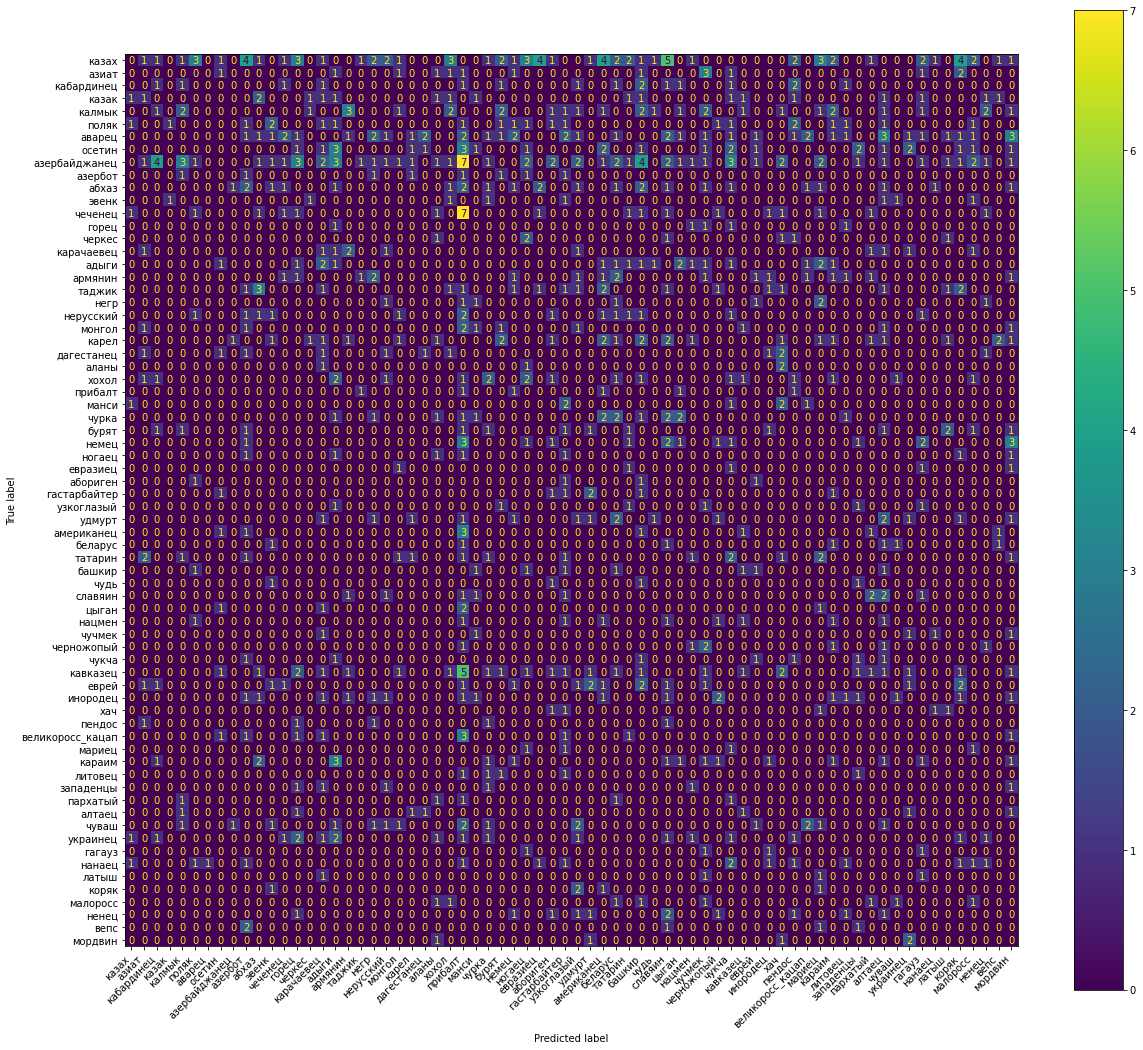

In [20]:
model_evaluate(best_DT, data[best_DT_var]["X_test"], data[best_DT_var]["y_test"]) # оцениваем предсказание лучшей модели на соответствующем типе обработки

**Feature importance для Decision Tree:**

In [109]:
features_count = len(data[best_DT_var]["vectorizer"].vocabulary_) # число фичей

importances = best_DT.feature_importances_ # значение feature importance

indices = np.argsort(importances)[::-1] # индексы элементов с самым большим значением feature importance

features_names = data[best_DT_var]["vectorizer"].get_feature_names_out() # имена фичей

In [110]:
print("Feature Decision Tree ranking:")
for feature in range(NUM_FEATURES): # идём по всем фичам
    print(f"Feature {feature+1} ({indices[feature]}) — '{features_names[indices[feature]]}': {importances[indices[feature]]:.5f}") # вывод информации о фичах

Feature Decision Tree ranking:
Feature 1 (11650) — 'русский': 0.16239
Feature 2 (14724) — 'это': 0.14258
Feature 3 (704) — 'br': 0.10356
Feature 4 (3666) — 'всё': 0.08498
Feature 5 (3256) — 'весь': 0.04520
Feature 6 (7215) — 'народ': 0.04391
Feature 7 (11518) — 'россия': 0.03491
Feature 8 (13983) — 'человек': 0.03449
Feature 9 (4855) — 'жить': 0.03430
Feature 10 (11835) — 'свой': 0.02950
Feature 11 (7346) — 'наш': 0.01539
Feature 12 (6117) — 'который': 0.01408
Feature 13 (12816) — 'татарин': 0.01128
Feature 14 (883) — 'http': 0.01102
Feature 15 (6967) — 'мочь': 0.01088
Feature 16 (13347) — 'украина': 0.00988
Feature 17 (13825) — 'хороший': 0.00982
Feature 18 (5244) — 'знать': 0.00946
Feature 19 (2793) — 'белорус': 0.00899
Feature 20 (14314) — 'чурка': 0.00789
Feature 21 (10257) — 'просто': 0.00782
Feature 22 (4213) — 'дагестан': 0.00701
Feature 23 (3624) — 'время': 0.00698
Feature 24 (4013) — 'год': 0.00638
Feature 25 (13349) — 'украинец': 0.00634
Feature 26 (4774) — 'ещё': 0.00599
Fea

## 4) Random Forest

In [ ]:
# params_RF = [{
#     "n_estimators": [5, 10, 25, 100, 300], # число деревьев в ансамбле
#     "criterion": ["gini", "entropy"], # критерий для оценивания качества разбиения
#     "max_depth": [None, 5, 10, 15], # лимит на максимальную глубину деревьев в ансамбле
#     "min_samples_split": [2, 5, 10],# минимальное число сэмплов в узле для разбиения
#     "max_features": [None, "sqrt", "log2"], # число рассматриваемых фичей ('столбцов' в датасете) при делении в узле (для best split)
#     "class_weight": [None, "balanced"], # балансировка весов для классов
#     # "random_state": [RANDOM_STATE], # число для задания случайности
#     }]

params_RF = [{
    "n_estimators": [20, 50, 100], # число деревьев в ансамбле
    "criterion": ["gini", "entropy"], # критерий для оценивания качества разбиения
    "max_depth": [5, 10], # лимит на максимальную глубину деревьев в ансамбле
    "min_samples_split": [10, 50, 100],# минимальное число сэмплов в узле для разбиения
    "max_features": ["sqrt", "log2"], # число рассматриваемых фичей ('столбцов' в датасете) при делении в узле (для best split)
    "class_weight": [None, "balanced"], # балансировка весов для классов
    "random_state": [RANDOM_STATE], # число для задания случайности
    }]

In [ ]:
models["RF"] = {} # создаём заготовку под классификатор

for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    gs_model = model_train(RandomForestClassifier(), params_RF, data[var]["X_train"], data[var]["y_train"], custom_cv) # вызываем скрипт обучения
    models["RF"][var] = gs_model # сохраняем то, что вернул GreedSearch

Находим лучшую комбинацию параметров модели и обработки датасета.

In [23]:
best_RF, best_RF_var = models_best(models["RF"]) # находим лучшую комбинацию параметров модели и обработки датасета

Лучший score=0.0176 при обработке 'all'


In [30]:
best_RF.get_params() # лучшие параметры

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 100,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [ ]:
model_save(best_RF, f"RF_{best_RF_var}") # сохраняем лучшую модель (с указанием варианта очистки текста)

In [13]:
# best_RF = model_load("RF_all")
# best_RF_var = "all"

                  precision    recall  f1-score   support

           казах       0.00      0.00      0.00        74
           азиат       0.00      0.00      0.00        15
      кабардинец       0.00      0.00      0.00        16
           казак       0.00      0.00      0.00        19
          калмык       0.00      0.00      0.00        32
           поляк       0.00      0.00      0.00        21
          аварец       0.00      0.00      0.00        45
          осетин       0.00      0.00      0.00        27
   азербайджанец       0.00      0.00      0.00        71
         азербот       0.00      0.00      0.00         8
           абхаз       0.00      0.00      0.00        25
           эвенк       0.00      0.00      0.00         8
         чеченец       0.00      0.00      0.00        23
           горец       0.02      0.20      0.04         5
          черкес       0.00      0.00      0.00         7
      карачаевец       0.00      0.00      0.00        11
           ад

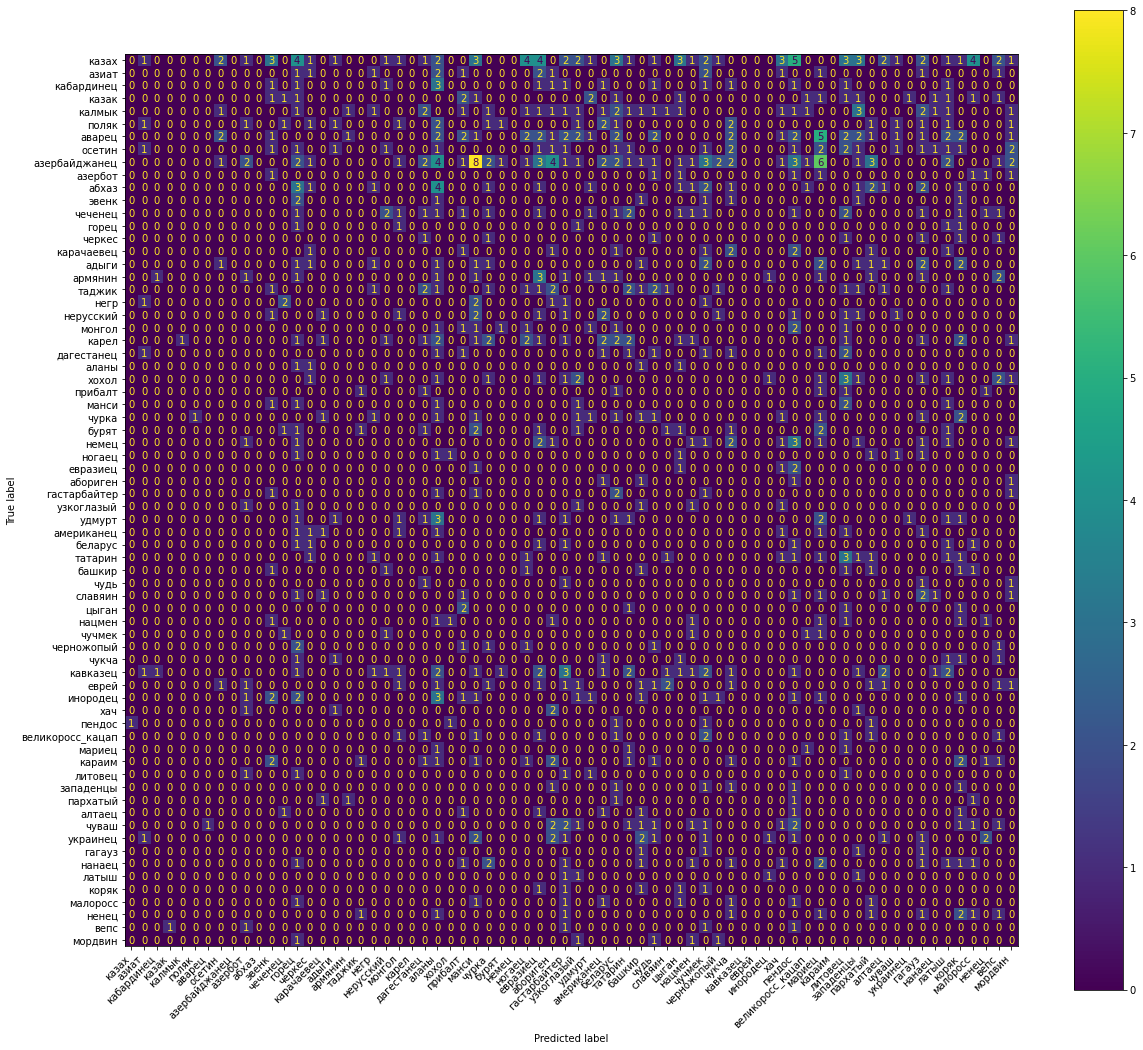

In [26]:
model_evaluate(best_RF, data[best_RF_var]["X_test"], data[best_RF_var]["y_test"]) # оцениваем предсказание лучшей модели на соответствующем типе обработки

**Feature importance для Random Forest:**

In [112]:
features_count = len(data[best_RF_var]["vectorizer"].vocabulary_) # число фичей

importances = best_RF.feature_importances_ # значение feature importance
# std = np.std([tree.feature_importances_ for tree in best_RF.estimators_], axis=0) # подсчёт стандартного отклонения

indices = np.argsort(importances)[::-1] # индексы элементов с самым большим значением feature importance

features_names = data[best_RF_var]["vectorizer"].get_feature_names_out() # имена фичей

In [113]:
print("Feature Random Forest ranking:")
for feature in range(NUM_FEATURES): # идём по всем фичам
    print(f"Feature {feature+1} ({indices[feature]}) — '{features_names[indices[feature]]}': {importances[indices[feature]]:.5f}") # вывод информации о фичах

Feature Random Forest ranking:
Feature 1 (1457) — 'война': 0.00756
Feature 2 (10884) — 'ссылка': 0.00554
Feature 3 (13173) — 'хороший': 0.00536
Feature 4 (10471) — 'славянин': 0.00533
Feature 5 (13189) — 'хотеть': 0.00503
Feature 6 (14461) — 'эвенк': 0.00478
Feature 7 (5250) — 'некоторый': 0.00452
Feature 8 (6091) — 'очень': 0.00450
Feature 9 (14669) — 'этнический': 0.00446
Feature 10 (11450) — 'также': 0.00439
Feature 11 (2282) — 'день': 0.00439
Feature 12 (9379) — 'революция': 0.00434
Feature 13 (2166) — 'дагестанец': 0.00413
Feature 14 (2770) — 'жизнь': 0.00412
Feature 15 (10247) — 'свой': 0.00402
Feature 16 (3537) — 'казах': 0.00402
Feature 17 (8032) — 'право': 0.00396
Feature 18 (11295) — 'считать': 0.00377
Feature 19 (2241) — 'девочка': 0.00360
Feature 20 (13113) — 'ходить': 0.00356
Feature 21 (4110) — 'кстати': 0.00353
Feature 22 (12218) — 'улица': 0.00344
Feature 23 (5279) — 'ненависть': 0.00340
Feature 24 (10845) — 'сразу': 0.00332
Feature 25 (4583) — 'менее': 0.00330
Feature 

# Вывод

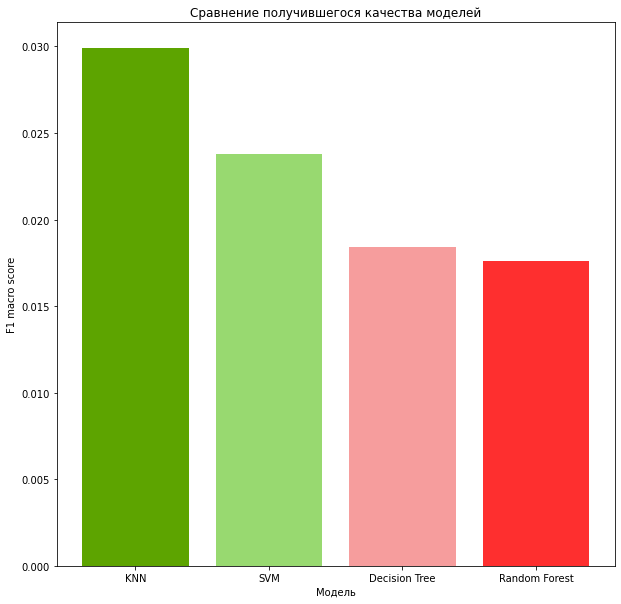

In [178]:
plt.figure(figsize=(10,10)) # задание размера графика
plt.bar(["KNN", "SVM", "Decision Tree", "Random Forest"], [0.0299, 0.0238, 0.0184, 0.0176], color=["#5da400", "#98d970", "#f69d9d", "#fe2f2f"]) # строим столбчатую диаграмму
plt.title('Сравнение получившегося качества моделей') # название графика
plt.xlabel('Модель') # подпись по оси x
plt.ylabel('F1 macro score') # подпись по оси y
plt.show() # вывод графика

* Из-за сложности данных в датасете, классические ML подходы плохо справились с задачей классификации.
* Модель, что лучше всего справилась — KNN, её score ~ 0.0299.
* Обработка при этом была — "trash", то есть удалялись субъективно мусорные символы в документах, такие как html элементы, теги, id...